In [29]:
import pandas as pd
import numpy as np
import random
random.seed(100)
import os
import tensorflow as tf 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [30]:
# load dataset
user_keywords = pd.read_csv('/Users/jun_yu/Desktop/Pull常驻通知/user_keywords.csv')

In [14]:
def date_process(user_item):
    """user_item is a DataFrame,
    只有两列column [user_id, keywords]
    1. user_item: user and item information, user_id, keywords, keyword_index
    2. user_index: user to index
    3. item_index：item to index
    """
    user_item["keywords"] = user_item["keywords"].apply(lambda x: x.split("|"))

    keyword_list = []
    print(type(user_item["keywords"])) # Series
    print("+++++++++++++++++++++")
    for i in user_item["keywords"].values:
        print(i)
        keyword_list.extend(i)

    # word count
    item_count = pd.DataFrame(pd.Series(keyword_list).value_counts())
    # add index to word_count
    item_count['id'] = list(range(0, len(item_count)))
    # 将word的id对应起来
    map_index = lambda x: list(item_count['id'][x])
    # 速度太慢
    user_item['keyword_index'] = user_item['keywords'].apply(map_index)
    # create user_index, item_index
    user_index = {v: k for k, v in user_item["user_id"].to_dict().items()}
    item_index = item_count["id"].to_dict()

    return user_item, user_index, item_index

In [32]:
user_keywords.head()

,user_id,keywords
0,113,新闻推荐|资讯推荐|内容推荐|文本分类|人工分类|自然语言处理|聚类|分类|冷启动
1,143,网络|睡眠|精神衰弱|声音|人工分类
2,123,新年愿望|梦想|2018|辞旧迎新
3,234,父母|肩头|饺子|蔬菜块|青春叛逆期|声音
4,117,新闻推荐|内容推荐|文本分类|人工分类|自然语言处理|聚类|分类|冷启动


In [33]:
user_keywords, user_index, keyword_index = date_process(user_keywords)

<class 'pandas.core.series.Series'>
+++++++++++++++++++++
['新闻推荐', '资讯推荐', '内容推荐', '文本分类', '人工分类', '自然语言处理', '聚类', '分类', '冷启动']
['网络', '睡眠', '精神衰弱', '声音', '人工分类']
['新年愿望', '梦想', '2018', '辞旧迎新']
['父母', '肩头', '饺子', '蔬菜块', '青春叛逆期', '声音']
['新闻推荐', '内容推荐', '文本分类', '人工分类', '自然语言处理', '聚类', '分类', '冷启动']
['新闻推荐', '资讯推荐', '人工分类', '自然语言处理', '聚类', '分类', '冷启动']
['新闻推荐', '资讯推荐', '内容推荐', '文本分类', '聚类', '分类', '冷启动']
['机器学习', '新闻推荐', '梦想', '人工分类', '自然语言处理']


In [39]:
print(user_keywords)

   user_id                                           keywords  \
0      113  [新闻推荐, 资讯推荐, 内容推荐, 文本分类, 人工分类, 自然语言处理, 聚类, 分类,...   
1      143                           [网络, 睡眠, 精神衰弱, 声音, 人工分类]   
2      123                             [新年愿望, 梦想, 2018, 辞旧迎新]   
3      234                       [父母, 肩头, 饺子, 蔬菜块, 青春叛逆期, 声音]   
4      117      [新闻推荐, 内容推荐, 文本分类, 人工分类, 自然语言处理, 聚类, 分类, 冷启动]   
5      119            [新闻推荐, 资讯推荐, 人工分类, 自然语言处理, 聚类, 分类, 冷启动]   
6       12              [新闻推荐, 资讯推荐, 内容推荐, 文本分类, 聚类, 分类, 冷启动]   
7      122                     [机器学习, 新闻推荐, 梦想, 人工分类, 自然语言处理]   

                 keyword_index  
0  [1, 6, 7, 8, 0, 4, 5, 2, 3]  
1           [19, 14, 11, 9, 0]  
2             [13, 10, 18, 16]  
3      [21, 17, 12, 22, 15, 9]  
4     [1, 7, 8, 0, 4, 5, 2, 3]  
5        [1, 6, 0, 4, 5, 2, 3]  
6        [1, 6, 7, 8, 5, 2, 3]  
7            [20, 1, 10, 0, 4]  


In [38]:
# 获取用户,item ID 及索引index  
# df, user_index: user_id: keyword_index 列表结构
print("user_keywords", user_keywords)   
print("user_index", user_index)
print("keyword_index", keyword_index)

user_index {113: 0, 143: 1, 123: 2, 234: 3, 117: 4, 119: 5, 12: 6, 122: 7}
keyword_index {'人工分类': 0, '新闻推荐': 1, '分类': 2, '冷启动': 3, '自然语言处理': 4, '聚类': 5, '资讯推荐': 6, '内容推荐': 7, '文本分类': 8, '声音': 9, '梦想': 10, '精神衰弱': 11, '饺子': 12, '新年愿望': 13, '睡眠': 14, '青春叛逆期': 15, '辞旧迎新': 16, '肩头': 17, '2018': 18, '网络': 19, '机器学习': 20, '父母': 21, '蔬菜块': 22}


In [15]:
def create_pairs(user_keywords, user_index):
    """
    generate user, keyword pair list
    """
    pairs = []
    def doc2tag(pairs, x):
        for index in x["keyword_index"]:
            pairs.append((user_index[x["user_id"]], index))
    # 速度太慢
    user_keywords.apply(lambda x: doc2tag(pairs, x), axis=1)
    return pairs

In [41]:
# 获取用户物品索引对 pair(user,item) , 分别对应索引id  
pairs = create_pairs(user_keywords, user_index)
print(pairs)
print(len(pairs))

[(0, 1), (0, 6), (0, 7), (0, 8), (0, 0), (0, 4), (0, 5), (0, 2), (0, 3), (1, 19), (1, 14), (1, 11), (1, 9), (1, 0), (2, 13), (2, 10), (2, 18), (2, 16), (3, 21), (3, 17), (3, 12), (3, 22), (3, 15), (3, 9), (4, 1), (4, 7), (4, 8), (4, 0), (4, 4), (4, 5), (4, 2), (4, 3), (5, 1), (5, 6), (5, 0), (5, 4), (5, 5), (5, 2), (5, 3), (6, 1), (6, 6), (6, 7), (6, 8), (6, 5), (6, 2), (6, 3), (7, 20), (7, 1), (7, 10), (7, 0), (7, 4)]
51


In [44]:
#  建立全连接网络 3 layers, relu 激活函数 
def build_embedding_model(embedding_size=50, classification = False):
    """
    根据用户行为相关的item ,if clicked by user
    Model to embed users and keywords using the Keras functional API.
    """
    # Both inputs are 1-dimensional
    user = tf.keras.Input(name='user',
                          shape=[1])
    keyword = tf.keras.Input(name='keyword',
                             shape=[1])

    # 50维 
    # Embedding the user default: (shape will be (None, 1, 50))
    user_embedding = tf.keras.layers.Embedding(name= 'user_embedding',
                                               input_dim= len(user_index),
                                               output_dim= embedding_size)(user)

    # Embedding the keyword default: (shape will be (None, 1, 50))
    keyword_embedding = tf.keras.layers.Embedding(name='keyword_embedding',
                                                  input_dim=len(keyword_index),
                                                  output_dim=embedding_size)(keyword)

    # Merge the layers with a dot product along the second axis
    # (shape will be (None, 1, 1))
    merged = tf.keras.layers.Dot(name='dot_product',
                                 normalize=True,
                                 axes=2)([user_embedding, keyword_embedding])
    
    # 1维 
    # Reshape to be a single number (shape will be (None, 1))
    merged = tf.keras.layers.Reshape(target_shape=[1])(merged)

    # Squash outputs for classification
    out = tf.keras.layers.Dense(1, 
                                activation='sigmoid')(merged)
    
    # 调用 keras Model处理， NN 神经网络  
    model = tf.keras.Model(inputs=[user, keyword],
                           outputs=out)
    
    # 定义梯度损失优化函数 Adam   
    # Compile using specified optimizer and loss
    model.compile(optimizer='Adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    print("++++++",model.summary())
    return model

In [45]:
model = build_embedding_model(embedding_size=20, classification=False)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
keyword (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 20)        160         user[0][0]                       
__________________________________________________________________________________________________
keyword_embedding (Embedding)   (None, 1, 20)        460         keyword[0][0]                    
____________________________________________________________________________________________

In [17]:
# 负采样
def generate_batch(pairs, n_positive = 50, negative_ratio = 1.0):
    """
    正样本从 用户观看序列pair 中随机选,
    负样本从 从全局序列中随机选；
    Generate batches of samples for training.
    Random select positive samples from pairs 
    and randomly select negatives.
    """
    # Create empty array to hold batch
    batch_size = n_positive * (1 + negative_ratio)
    batch = np.zeros((batch_size, 3))

    # Continue to yield samples
    while True:
        # Randomly choose positive examples
        # 采样数不能超过 pairs 的个数, 这里pairs的length 是51个  
        for idx, (user_id, keyword_id) in enumerate(random.sample(pairs, n_positive)):
            batch[idx, :] = (user_id, keyword_id, 1)
        idx += 1

        # Add negative examples until reach batch size
        while idx < batch_size:
            # Random selection
            random_user = random.randrange(len(user_index))
            random_keyword = random.randrange(len(keyword_index))

            # print(random_user, random_keyword)
            # Check to make sure this is not a positive example
            if (random_user, random_keyword) not in pairs:
                # Add to batch and increment index
                batch[idx, :] = (random_user, random_keyword, 0)
                idx += 1

        # Make sure to shuffle order
        np.random.shuffle(batch)
        yield {'user': batch[:, 0], 'keyword': batch[:, 1]}, batch[:, 2]

In [46]:
n_positive = len(pairs)
gen = generate_batch(pairs, n_positive, negative_ratio=1)

In [56]:
pairs[:10] 

[(0, 1),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 0),
 (0, 4),
 (0, 5),
 (0, 2),
 (0, 3),
 (1, 19)]

In [67]:
len(pairs)

51

In [62]:
## 创建 100行,3列的 空array数组  
negative_ratio = 1.0 
n_positive = 50 
# Create empty array to hold batch
batch_size = int(n_positive * (1 + negative_ratio))
batch = np.zeros((batch_size, 3))

In [66]:
batch[:5]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [78]:
for idx, (user_id,keyword_id)  in enumerate(random.sample(pairs, n_positive)):
    print(idx, (user_id, keyword_id))
    batch[idx, :] = (user_id, keyword_id, 1)
idx += 1

0 (2, 16)
1 (6, 6)
2 (0, 6)
3 (5, 6)
4 (0, 0)
5 (1, 19)
6 (5, 1)
7 (7, 0)
8 (4, 0)
9 (6, 1)
10 (0, 1)
11 (4, 4)
12 (1, 14)
13 (0, 4)
14 (3, 21)
15 (6, 2)
16 (7, 20)
17 (2, 13)
18 (5, 4)
19 (3, 15)
20 (6, 3)
21 (5, 0)
22 (1, 11)
23 (1, 9)
24 (0, 7)
25 (5, 5)
26 (0, 8)
27 (7, 10)
28 (7, 1)
29 (0, 2)
30 (4, 1)
31 (3, 17)
32 (6, 7)
33 (5, 2)
34 (3, 12)
35 (7, 4)
36 (0, 3)
37 (5, 3)
38 (2, 10)
39 (0, 5)
40 (4, 5)
41 (3, 9)
42 (3, 22)
43 (4, 3)
44 (6, 8)
45 (4, 7)
46 (4, 2)
47 (1, 0)
48 (6, 5)
49 (2, 18)


In [83]:
len(batch), batch.shape

(100, (100, 3))

In [ ]:
# Continue to yield samples
while True:
    # Randomly choose positive examples
    for idx, (user_id, keyword_id) in enumerate(random.sample(pairs, n_positive)):
        batch[idx, :] = (user_id, keyword_id, 1)
    idx += 1

    # Add negative examples until reach batch size
    while idx < batch_size:
        # Random selection
        random_user = random.randrange(len(user_index))
        random_keyword = random.randrange(len(keyword_index))

        # print(random_user, random_keyword)
        # Check to make sure this is not a positive example
        if (random_user, random_keyword) not in pairs:
            # Add to batch and increment index
            batch[idx, :] = (random_user, random_keyword, 0)
            idx += 1

    # Make sure to shuffle order
    np.random.shuffle(batch)
    yield {'user': batch[:, 0], 'keyword': batch[:, 1]}, batch[:, 2]

In [21]:

# Train
h = model.fit_generator(gen, epochs=100, steps_per_epoch=len(pairs) // n_positive)

# Extract embeddings
user_layer = model.get_layer('user_embedding')
user_weights = user_layer.get_weights()[0]

keyword_layer = model.get_layer('keyword_embedding')
keyword_weights = keyword_layer.get_weights()[0]

Epoch 1/100
1/1 [==============================] - 0s 231ms/step - loss: 0.7019 - accuracy: 0.4216
Epoch 2/100
1/1 [==============================] - 0s 37ms/step - loss: 0.7086 - accuracy: 0.4412
Epoch 3/100
1/1 [==============================] - 0s 48ms/step - loss: 0.6890 - accuracy: 0.4902
Epoch 4/100
1/1 [==============================] - 0s 44ms/step - loss: 0.7237 - accuracy: 0.4118
Epoch 5/100
1/1 [==============================] - 0s 55ms/step - loss: 0.7297 - accuracy: 0.4706
Epoch 6/100
1/1 [==============================] - 0s 62ms/step - loss: 0.7016 - accuracy: 0.5098
Epoch 7/100
1/1 [==============================] - 0s 47ms/step - loss: 0.7324 - accuracy: 0.4118
Epoch 8/100
1/1 [==============================] - 0s 49ms/step - loss: 0.6823 - accuracy: 0.5588
Epoch 9/100
1/1 [==============================] - 0s 71ms/step - loss: 0.6819 - accuracy: 0.5392
Epoch 10/100
1/1 [==============================] - 0s 74ms/step - loss: 0.7049 - accuracy: 0.5098
Epoch 11/100
1/1 [

Epoch 84/100
1/1 [==============================] - 0s 35ms/step - loss: 0.4228 - accuracy: 0.9510
Epoch 85/100
1/1 [==============================] - 0s 55ms/step - loss: 0.7542 - accuracy: 0.5196
Epoch 86/100
1/1 [==============================] - 0s 49ms/step - loss: 0.4193 - accuracy: 0.9706
Epoch 87/100
1/1 [==============================] - 0s 37ms/step - loss: 0.4149 - accuracy: 0.9902
Epoch 88/100
1/1 [==============================] - 0s 45ms/step - loss: 0.4032 - accuracy: 0.9804
Epoch 89/100
1/1 [==============================] - 0s 52ms/step - loss: 0.4017 - accuracy: 0.9608
Epoch 90/100
1/1 [==============================] - 0s 51ms/step - loss: 0.6887 - accuracy: 0.5686
Epoch 91/100
1/1 [==============================] - 0s 40ms/step - loss: 0.7439 - accuracy: 0.6078
Epoch 92/100
1/1 [==============================] - 0s 55ms/step - loss: 0.7487 - accuracy: 0.4412
Epoch 93/100
1/1 [==============================] - 0s 52ms/step - loss: 0.7835 - accuracy: 0.5000
Epoch 94/1

In [22]:
print("user_weights<<<<<<<<<<<<<<<<",user_weights)
print("word_weights<<<<<<<<<<<<<<<<",keyword_weights)

user_weights<<<<<<<<<<<<<<<< [[ 3.09637282e-02 -2.37099528e-02  1.62288919e-02 -7.07484409e-02
  -6.11395761e-03  1.63467159e-03  4.82127964e-02  4.96753715e-02
  -9.78266262e-03  6.98231682e-02  4.79116477e-02 -1.55000957e-02
  -6.21189103e-02  1.90602224e-02 -4.11579572e-02  2.20483001e-02
  -1.62875548e-03 -3.70597504e-02  5.83592476e-03 -7.51909055e-03]
 [-6.01839870e-02 -2.37399321e-02 -3.36647630e-02 -2.54096463e-02
   8.54421966e-03  4.25762422e-02 -2.97086849e-03  6.59334334e-03
  -1.03700543e-02  7.14505650e-03 -3.96692306e-02  6.94450969e-03
  -3.95261683e-02  4.66429517e-02  3.78991552e-02  6.94792019e-03
  -6.88189641e-02  1.71536449e-02 -5.68379201e-02  3.44302692e-02]
 [ 2.57407781e-02 -5.67690320e-02  2.80867256e-02  5.88537380e-02
  -3.53545807e-02  1.87111441e-02 -3.52510158e-03 -1.01150991e-02
   3.12948525e-02 -3.72253656e-02 -1.03871077e-02 -6.50873408e-02
  -9.75976815e-04 -4.40456942e-02 -3.26272734e-02 -9.76784900e-03
  -7.41525227e-03  6.40498847e-02  1.34065766

In [23]:
#calculate cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
print(user_weights[0:1])

[[ 0.03096373 -0.02370995  0.01622889 -0.07074844 -0.00611396  0.00163467
   0.0482128   0.04967537 -0.00978266  0.06982317  0.04791165 -0.0155001
  -0.06211891  0.01906022 -0.04115796  0.0220483  -0.00162876 -0.03705975
   0.00583592 -0.00751909]]


In [24]:
#计算第1个用户与其他用户的相似系数
cos = cosine_similarity(user_weights[0:1], user_weights)
recommendations = cos[0].argsort()[-4:][::-1]
print("++++++++++",cos)
print("**********",recommendations)

++++++++++ [[ 0.9999999  -0.01685169 -0.22256094 -0.48485026  0.95683956  0.8507678
   0.818949    0.19291675]]
********** [0 4 5 6]


[[-1.0553447e-01 -1.1883489e-02]
 [ 6.2193949e-02 -5.4816421e-02]
 [ 8.6953446e-02  1.4526501e-01]
 [ 1.3923810e-01 -1.0809699e-01]
 [-6.7732185e-02 -1.7343177e-02]
 [-7.7704996e-02 -2.9444003e-05]
 [-8.0601893e-02 -1.1086222e-02]
 [ 4.3188032e-02  5.7990763e-02]]
[-0.10553447  0.06219395  0.08695345  0.1392381  -0.06773219 -0.077705
 -0.08060189  0.04318803]
[-1.1883489e-02 -5.4816421e-02  1.4526501e-01 -1.0809699e-01
 -1.7343177e-02 -2.9444003e-05 -1.1086222e-02  5.7990763e-02]


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


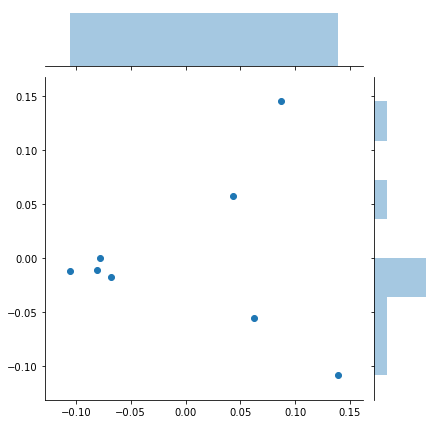

In [25]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

#主成分PCA可视化
pca = PCA(n_components=2)
pca_result = pca.fit_transform(user_weights)
print(pca_result)
print(pca_result[:,0])
print(pca_result[:,1])

sns.jointplot(x=pca_result[:,0], y=pca_result[:,1])
plt.show()

     total_bill   tip     sex smoker   day    time  size
0         16.99  1.01  Female     No   Sun  Dinner     2
1         10.34  1.66    Male     No   Sun  Dinner     3
2         21.01  3.50    Male     No   Sun  Dinner     3
3         23.68  3.31    Male     No   Sun  Dinner     2
4         24.59  3.61  Female     No   Sun  Dinner     4
5         25.29  4.71    Male     No   Sun  Dinner     4
6          8.77  2.00    Male     No   Sun  Dinner     2
7         26.88  3.12    Male     No   Sun  Dinner     4
8         15.04  1.96    Male     No   Sun  Dinner     2
9         14.78  3.23    Male     No   Sun  Dinner     2
10        10.27  1.71    Male     No   Sun  Dinner     2
11        35.26  5.00  Female     No   Sun  Dinner     4
12        15.42  1.57    Male     No   Sun  Dinner     2
13        18.43  3.00    Male     No   Sun  Dinner     4
14        14.83  3.02  Female     No   Sun  Dinner     2
15        21.58  3.92    Male     No   Sun  Dinner     2
16        10.33  1.67  Female  

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


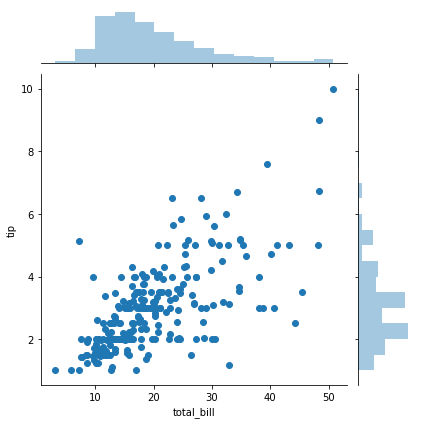

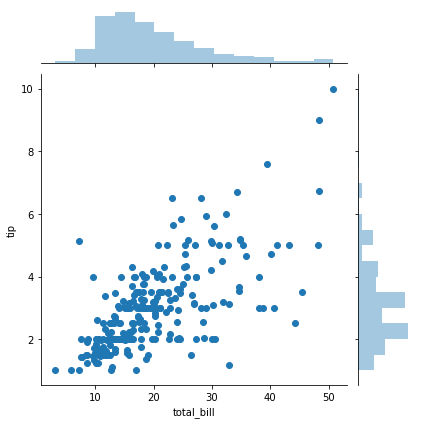

In [26]:
# 二维数据交互关系展示
tips = sns.load_dataset("tips")
print(tips)
print(type(tips))
g = sns.jointplot(x="total_bill", y="tip", data=tips)
g2 = sns.jointplot(x="total_bill", y="tip", data=tips, kind="scatter")
plt.show()